In [1]:
#%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string

import scipy as sp
from scipy import sparse
import sklearn

## add your packages ##

import time
import pickle
#import memory_profiler
from packaging.version import parse as parse_version
from memory_profiler import profile

# Load the memory_profiler extension
#get_ipython().run_line_magic('load_ext', 'memory_profiler')

from pathlib import Path

In [2]:
import black
import jupyter_black

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

jupyter_black.load(line_length=79)

Last updated: 2024-07-25 20:27:47Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.26.0

sklearn: 1.5.1

jupyter_black: 0.3.4
scipy        : 1.14.0
matplotlib   : 3.9.1
pandas       : 2.2.2
black        : 24.4.2
sklearn      : 1.5.1
numpy        : 2.0.0

Watermark: 2.4.3



In [3]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [4]:
plt.style.use("../matplotlib_style.txt")

In [5]:
np.random.seed(42)

printed 'Fuck off' three times actually again

In [6]:
print(2 * "Fuck off")

Fuck offFuck off


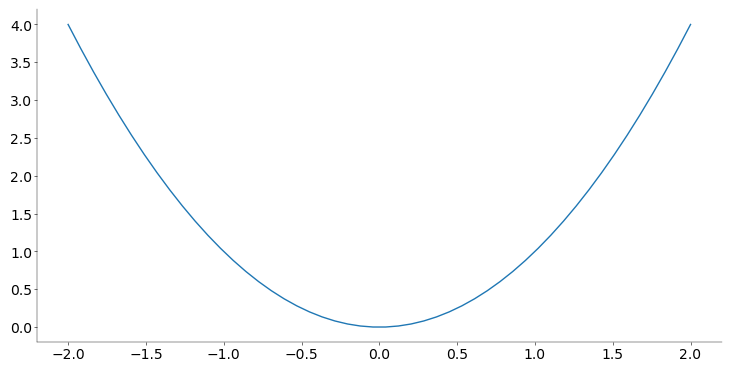

In [7]:
x = np.linspace(-2, 2)
y = x**2
plt.plot(x, y)
plt.show()

Text(0.5, 1.0, 'wqe')

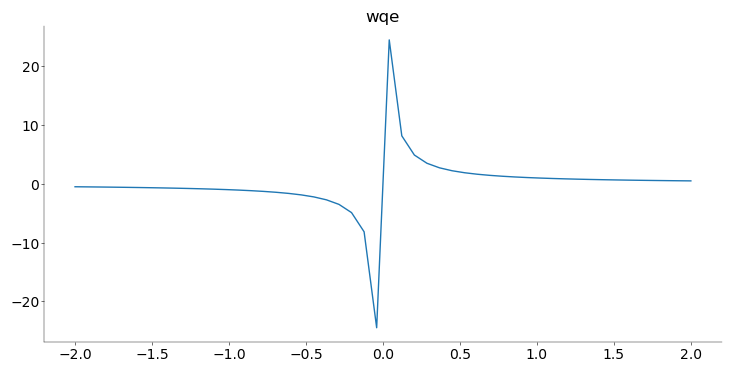

In [8]:
x = np.linspace(-2, 2)
y = 1 / x
plt.plot(x, y)
plt.title("wqe")

# Data

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [9]:
# META DATA

meta = pd.read_csv(data_path / "m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [c if c[-1] != "+" and c[-1] != "-" else c[:-1] for c in meta["Cre"].values]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [np.unique(meta["Date"].values[mice_names == m]).size == 1 for m in mice_names]
)
assert np.all(
    [np.unique(meta["Mouse age"].values[mice_names == m]).size == 1 for m in mice_names]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [np.unique(meta["Mouse"].values[sliceids == s]).size == 1 for s in sliceids]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [10]:
# READ COUNTS

data_exons = pd.read_csv(
    data_path / "m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape, "(cells x genes)")

Count matrix shape (exon):   (1329, 42466) (cells x genes)


In [11]:
data_exons

,20171204_sample_2,20171204_sample_4,20171204_sample_5,20171204_sample_6,20171207_sample_1,20171207_sample_2,20171207_sample_6,20171207_sample_7,20171219_sample_1,20171219_sample_2,...,20191114_sample_9,20200106_sample_1,20200106_sample_4,20200106_sample_5,20200106_sample_6,20200225_sample_2,20200225_sample_5,20200316_sample_1,20200316_sample_2,20200316_sample_3
0610005C13Rik,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0610006L08Rik,0,0,0,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610009B22Rik,0,68,1291,0,0,0,227,0,7,10,...,0,271,0,0,0,0,138,0,78,89
0610009E02Rik,0,0,0,0,30,80,205,0,0,14,...,0,0,0,0,0,0,1,0,0,0
0610009L18Rik,0,0,0,0,0,99,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-R5s98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n-TSaga9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# GENE LENGTH

data = pd.read_csv(data_path / "gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

### Cluster colors

In [13]:
cluster_colors = np.load(data_path / "cluster_colors.npy")

In [14]:
cluster_colors.shape

(1329,)

In [15]:
rna_type = np.load(data_path / "rna_type.npy", allow_pickle=True)

In [48]:
rna_type.shape

(1329,)

In [17]:
pickle_in = open(data_path / "dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)

In [18]:
len(dict_rna_type_colors)

88

### Electrophysiological features

In [19]:
# EPHYS DATA

ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [names2ephys[c] if c in names2ephys else ephysData[0] * np.nan for c in cells]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [20]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1329, 29)
(1320, 17)


In [21]:
np.sum(np.isnan(ephysData_filtered))

np.int64(0)

# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    

1) 

electrophysiology data: sparsity, activity, mean per neuron, (comparrison and enrichment study, gene ontology scores)
vulcano plots, get morphological data, 



In [22]:
# load morphology data
morphologyData = pd.read_csv(data_path / "m1_patchseq_morph_features.csv")

(1329,)
0            L5 ET_1
1            L5 IT_2
2            L5 IT_1
3            L5 ET_4
4            L5 ET_1
            ...     
1324       L4/5 IT_2
1325    Sncg Calb1_1
1326         L5 ET_1
1327             NaN
1328    Pvalb Gpr149
Length: 1329, dtype: object
Number of NaNs in rna_type: 97
{'L2/3 IT_3': 85, 'Pvalb Il1rapl2': 85, 'Pvalb Reln': 76, 'L6 CT Cpa6': 65, 'Sst Calb2': 61, 'L5 IT_1': 59, 'Sst Hpse': 48, 'Lamp5 Slc35d3': 39, 'Vip Mybpc1_2': 34, 'L4/5 IT_2': 33, 'L5 ET_1': 32, 'Pvalb Gpr149': 32, 'Sst Pvalb Calb2': 26, 'Pvalb Calb1_2': 26, 'L6 IT_2': 25, 'Vip Gpc3': 24, 'Vip Sncg': 23, 'L4/5 IT_1': 23, 'Lamp5 Pdlim5_2': 21, 'Pvalb Kank4': 20, 'Sst Th_3': 18, 'L6 CT Pou3f2': 17, 'Pvalb Vipr2_2': 17, 'Vip Chat_1': 16, 'Vip Mybpc1_3': 16, 'Sst Myh8_1': 16, 'Sst Crhr2_1': 16, 'Pvalb Calb1_1': 16, 'Sst Chodl': 14, 'Pvalb Egfem1': 11, 'Sst Crhr2_2': 11, 'Lamp5 Egln3_2': 10, 'Sst Etv1': 10, 'L6 IT_1': 10, 'Vip Serpinf1_1': 10, 'Lamp5 Egln3_1': 10, 'L5 ET_4': 9, 'Sst Th_1': 9, 'Ss

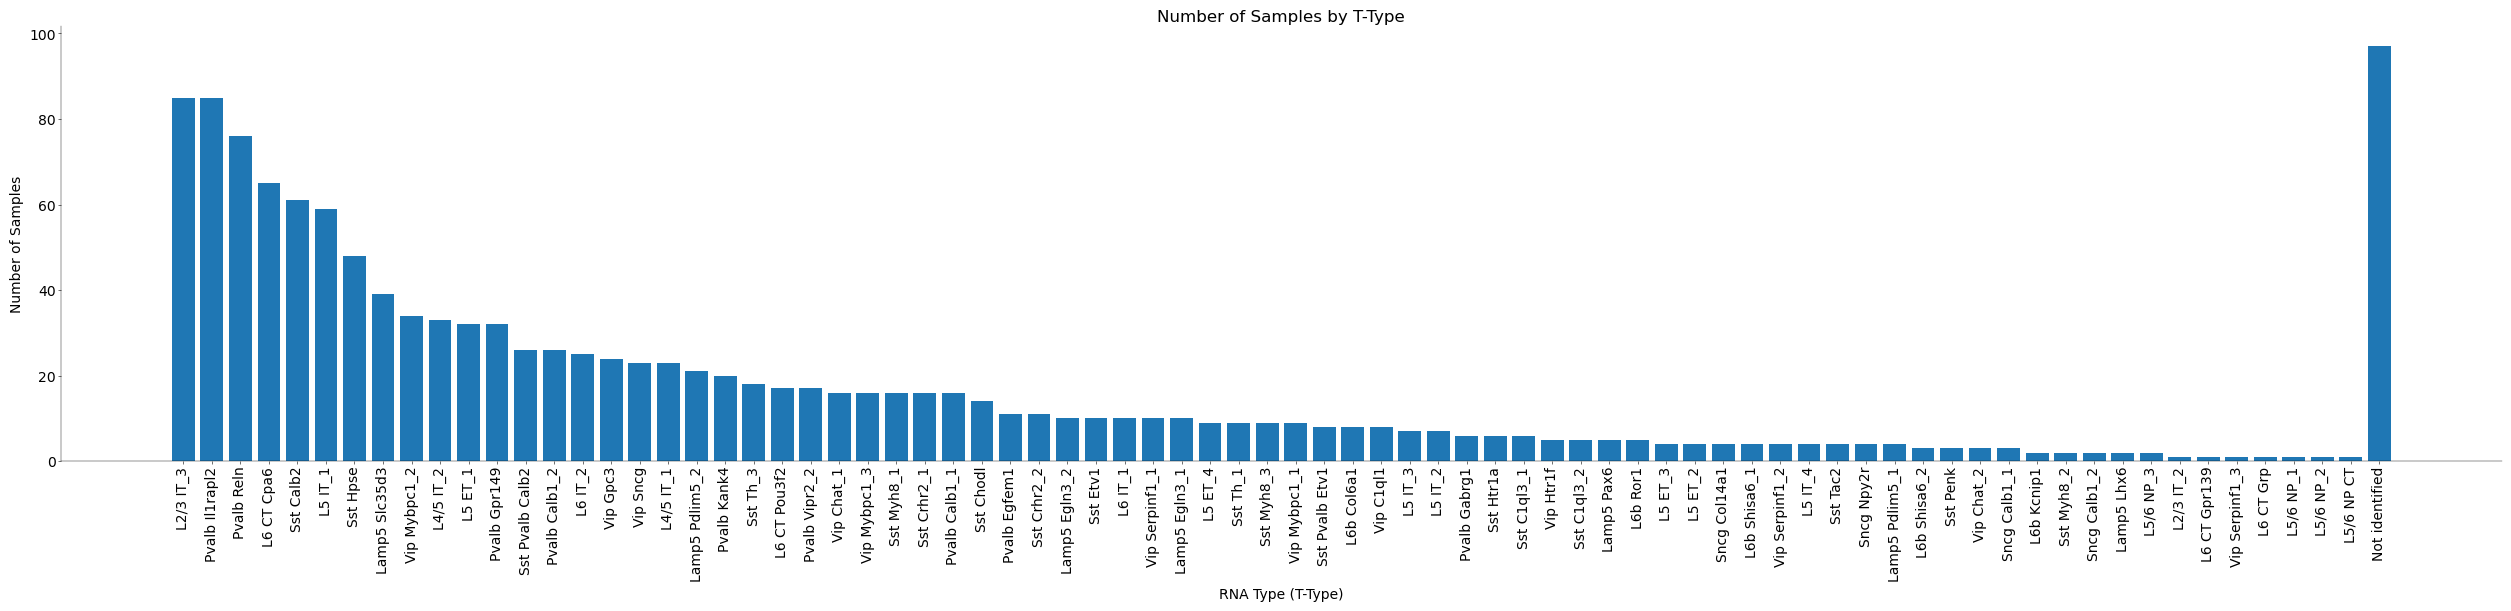

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert rna_type to a Pandas Series if it is not already
if not isinstance(rna_type, pd.Series):
    rna_type = pd.Series(rna_type)

# Check the shape and print the rna_type array
print(rna_type.shape)
print(rna_type)

# Check for NaNs in rna_type
print("Number of NaNs in rna_type:", rna_type.isnull().sum())

# Remove NaNs from rna_type if they exist
rna_type_clean = rna_type.dropna()

# Count occurrences of each RNA type
rna_type_counts = rna_type_clean.value_counts()

# Convert to dictionary for plotting
rna_type_dict = rna_type_counts.to_dict()

# Print the dictionary to see the counts
print(rna_type_dict)

# print the total number of counts
print("Total number of samples:", rna_type_clean.shape[0])

# Add a 'NaN' key to the dictionary if there were NaNs in the original rna_type array with the value of the count of NaNs
if rna_type.isnull().sum() > 0:
    rna_type_dict["Not identified"] = rna_type.isnull().sum()

# Plot the number of samples for each RNA type
plt.figure(figsize=(25, 6))  # Optional: Adjust figure size
plt.bar(rna_type_dict.keys(), rna_type_dict.values())
plt.xlabel("RNA Type (T-Type)")
plt.ylabel("Number of Samples")
plt.title("Number of Samples by T-Type")
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability
plt.show()

[264.97393209 138.57627278 435.15259266 ...   9.30473791  11.06779541
   9.80271276]


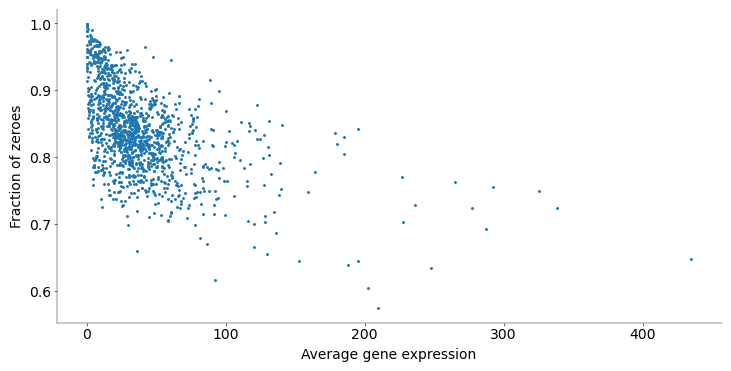

In [23]:
# calculate the average gene expression for each cell
average_gene_expression = np.mean(exonCounts, axis=1)
print(average_gene_expression)
# compute the fraction of zeroes for each cell
fraction_zeroes = np.sum(exonCounts == 0, axis=1) / exonCounts.shape[1]

# plot the average gene expression against the fraction of zeroes
plt.figure()
plt.scatter(average_gene_expression, fraction_zeroes, s=5)
plt.xlabel("Average gene expression")
plt.ylabel("Fraction of zeroes")
plt.show()

In [24]:
# normalise the data with house keeping genes
# find a gene called "Actb" and "Gapdh" in the exon counts
genes = data_exons.index
housekeeping = ["Actb"]
print(np.where(genes == housekeeping[0]))
print(genes[2624])

# find the index of the housekeeping genes in the gene list
idx_housekeeping = [np.where(genes == hk)[0][0] for hk in housekeeping]
print(idx_housekeeping)

# normalise each sample with the counts of actb
print(exonCounts.shape, exonCounts[:, idx_housekeeping[0]])
# devide all gene expression values for all samples by the corresponding actb gene expression value
exonCounts_norm = exonCounts / exonCounts[:, idx_housekeeping]
print(exonCounts_norm, exonCounts_norm.shape)
# calculate the average gene expression for each cell
average_gene_expression_norm = np.mean(exonCounts_norm, axis=0)
print(average_gene_expression_norm, average_gene_expression_norm.shape)

(array([2624]),)
Actb
[np.int64(2624)]
(1329, 42466) [15011  4819 57490 ...   529  2746  1218]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.01411081 ... 0.         0.         0.        ]
 [0.         0.         0.02245608 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.02840495 ... 0.         0.         0.        ]
 [0.         0.         0.07307061 ... 0.         0.         0.        ]] (1329, 42466)
[nan nan nan ... nan nan nan] (42466,)


C:\Users\Arne.Gittel\AppData\Local\Temp\ipykernel_11448\1747302482.py:15: RuntimeWarning: divide by zero encountered in divide
  exonCounts_norm = exonCounts / exonCounts[:, idx_housekeeping]
C:\Users\Arne.Gittel\AppData\Local\Temp\ipykernel_11448\1747302482.py:15: RuntimeWarning: invalid value encountered in divide
  exonCounts_norm = exonCounts / exonCounts[:, idx_housekeeping]


Indices of housekeeping genes: [np.int64(2624), np.int64(8851)]
Normalized exon counts:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.02240896 ... 0.         0.         0.        ]
 [0.         0.         0.03847873 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.046875   ... 0.         0.         0.        ]
 [0.         0.         0.09758772 ... 0.         0.         0.        ]]
Average gene expression for each gene:
[1.63305729e-03 2.39638303e-06 2.61305913e-02 ... 2.45451757e-04
 1.88833524e-05 7.36170852e-06]
Shape of normalized exon counts: (1329, 42466)


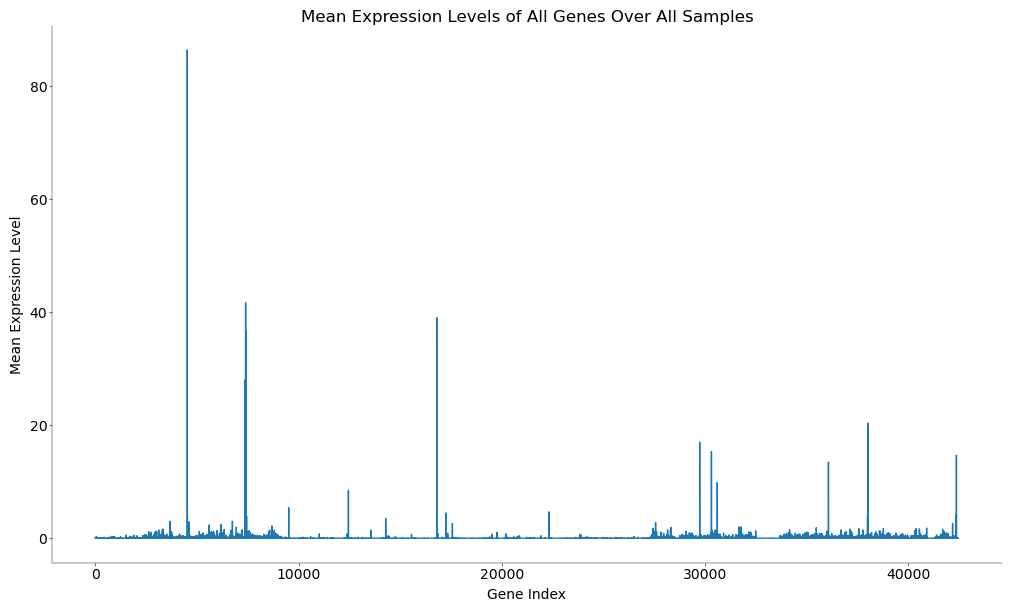

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data structure, replace these with your actual data
# List of housekeeping genes
housekeeping = ["Actb", "Gapdh"]

# Extract the list of genes from the data
genes = data_exons.index

# Find the indices of the housekeeping genes
idx_housekeeping = [np.where(genes == hk)[0][0] for hk in housekeeping]
print(f"Indices of housekeeping genes: {idx_housekeeping}")

# Normalize each sample with the counts of Actb and Gapdh
# Assume exonCounts is a numpy array of shape (number_of_samples, number_of_genes)

# Create an empty array to store normalized counts
exonCounts_norm = np.zeros_like(exonCounts, dtype=float)

# Normalize each sample by the counts of housekeeping genes
for i in range(exonCounts.shape[0]):  # For each sample
    norm_factor = exonCounts[
        i, idx_housekeeping
    ].mean()  # Average counts of housekeeping genes for the sample
    if norm_factor == 0:
        print(
            f"Warning: Zero normalization factor in sample {i}, setting normalization factor to 1 to avoid division by zero."
        )
        norm_factor = 1
    exonCounts_norm[i] = exonCounts[i] / norm_factor

print(f"Normalized exon counts:\n{exonCounts_norm}")

# Calculate the average gene expression for each gene across all samples
average_gene_expression_norm = np.mean(exonCounts_norm, axis=0)
print(f"Average gene expression for each gene:\n{average_gene_expression_norm}")

# The shape of exonCounts_norm is (number_of_samples, number_of_genes)
print(f"Shape of normalized exon counts: {exonCounts_norm.shape}")

# Plot the mean expression levels over all genes
plt.figure(figsize=(10, 6))
plt.plot(average_gene_expression_norm)
plt.xlabel("Gene Index")
plt.ylabel("Mean Expression Level")
plt.title("Mean Expression Levels of All Genes Over All Samples")
plt.show()

In [26]:
# normalisation using bioinfotoolkit
from bioinfokit.analys import norm, get_data

# print head of the data
print("raw data: ", data_exons.head(2))

# using cpm normalization
nm = norm()
nm.cpm(df=data_exons)
# get CPM normalized dataframe
cpm_df = nm.cpm_norm
print("cpm: ", cpm_df.head(2))
print("cpm: ", cpm_df.to_numpy())
# print the minimal value after normalization and object type
print("min value after cpm normalization: ", cpm_df.min().min(), cpm_df.dtypes)

# using rpkm normalization
print(exonLengths, exonLengths.shape)

# add gene length to the corresponding gene id
# find the matching gene id in data exons and gene data and add the gene length to the data exons
data_genes = pd.read_csv(data_path / "gene_lengths.txt")

data_exons.index.name = "GeneID"

# Perform the merge
merged_exon_data = pd.merge(data_exons, data_genes, on="GeneID", how="left")
merged_exon_data.set_index("GeneID", inplace=True)
merged_exon_data = merged_exon_data.drop(columns=["intron_bp", "gene_bp"])

# Print the head of the merged data
print("merged: ", merged_exon_data.head(2))

nm.rpkm(df=merged_exon_data, gl="exon_bp")

# get RPKM normalized dataframe
rpkm_df = nm.rpkm_norm

print("RPKM normalized data: ", rpkm_df.head(2))
print("RPKM normalized data: ", rpkm_df.to_numpy())
# using tpm normalization

nm.tpm(df=merged_exon_data, gl="exon_bp")

# get TPM normalized dataframe
tpm_df = nm.tpm_norm

print("TPM normalized data: ", tpm_df.head(2))

raw data:                 20171204_sample_2  20171204_sample_4  20171204_sample_5  \
0610005C13Rik                  0                  0                  0   
0610006L08Rik                  0                  0                  0   

               20171204_sample_6  20171207_sample_1  20171207_sample_2  \
0610005C13Rik                  0                  0                  1   
0610006L08Rik                  0                  0                 13   

               20171207_sample_6  20171207_sample_7  20171219_sample_1  \
0610005C13Rik                  0                  0                  0   
0610006L08Rik                  0                  0                  0   

               20171219_sample_2  ...  20191114_sample_9  20200106_sample_1  \
0610005C13Rik                  0  ...                  0                  0   
0610006L08Rik                  0  ...                  0                  0   

               20200106_sample_4  20200106_sample_5  20200106_sample_6  \
0610005C

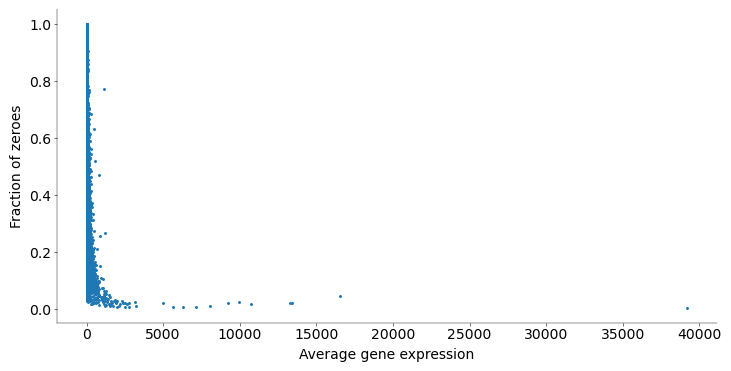

In [27]:
### for the cpm data

cpm_exonCounts = cpm_df.values.transpose()

# calculate the average gene expression for each cell
average_gene_expression_cpm = np.mean(cpm_exonCounts, axis=0)

# compute the fraction of zeroes for each cell
fraction_zeroes_cpm = np.mean(cpm_exonCounts == 0, axis=0)

# plot the average gene expression against the fraction of zeroes
plt.figure()
plt.scatter(average_gene_expression_cpm, fraction_zeroes_cpm, s=5)
plt.xlabel("Average gene expression")
plt.ylabel("Fraction of zeroes")
# make the plot loglog
# plt.xscale("log")
# plt.yscale("log")

plt.show()

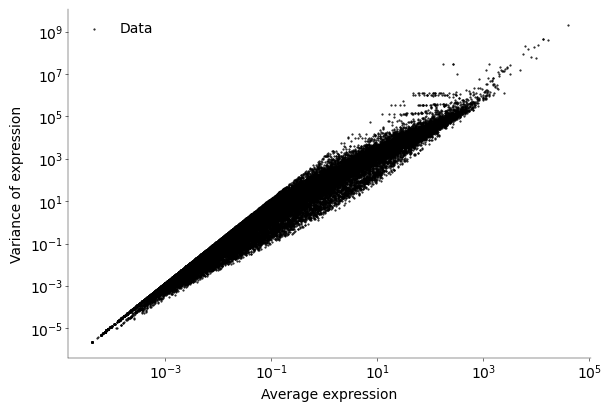

In [28]:
# Compute the variance of the expression counts of each gene
variance_gene_expression = np.var(cpm_exonCounts, axis=0)

fig, ax = plt.subplots(figsize=(6, 4))


ax.scatter(
    average_gene_expression_cpm,
    variance_gene_expression,
    s=1,
    color="black",
    label="Data",
)

# add labels
ax.set_xlabel("Average expression")
ax.set_ylabel("Variance of expression")
# add legend
ax.legend()

# make axis logarithmix
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

C:\Users\Arne.Gittel\AppData\Local\Temp\ipykernel_11448\1867521566.py:2: RuntimeWarning: invalid value encountered in divide
  fano_factor = variance_gene_expression / average_gene_expression_cpm


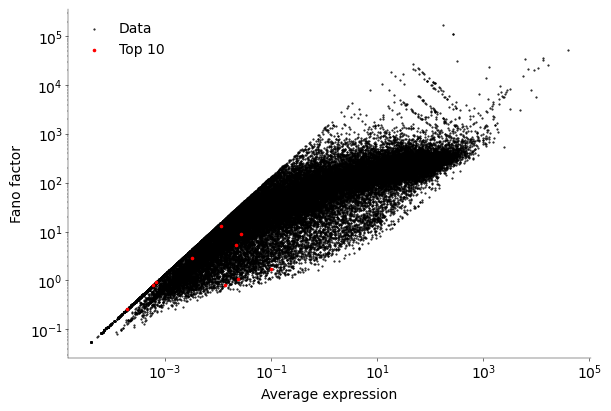

In [29]:
# compute the fano factor
fano_factor = variance_gene_expression / average_gene_expression_cpm

fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(average_gene_expression_cpm, fano_factor, s=1, color="black", label="Data")
top10 = np.argsort(~np.isnan(fano_factor))[-10:]
# mark the top 10 fanofactors red
ax.scatter(
    average_gene_expression_cpm[top10],
    fano_factor[top10],
    s=10,
    color="red",
    label="Top 10",
)

# add labels
ax.set_xlabel("Average expression")
ax.set_ylabel("Fano factor")
# add legend
ax.legend()

# make axis logarithmic
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

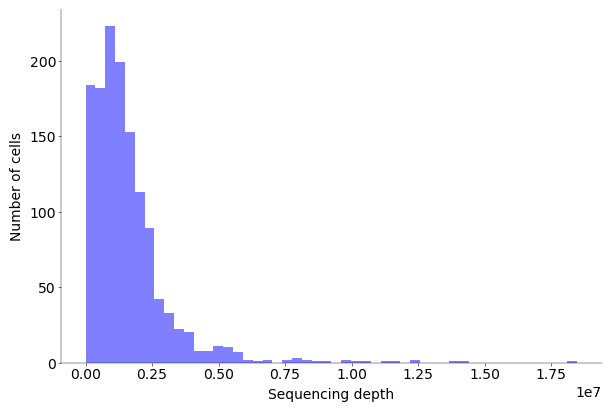

In [30]:
# plot sequencing depth
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(exonCounts.sum(axis=1), bins=50, color="blue", alpha=0.5)
# add labels
ax.set_xlabel("Sequencing depth")
ax.set_ylabel("Number of cells")
plt.show()

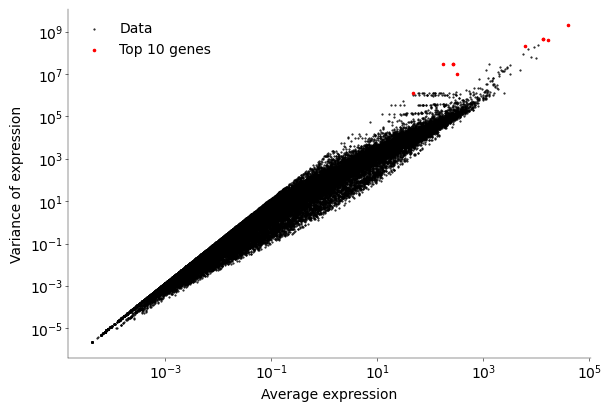

In [31]:
# Exclude NaNs from fano_factor
valid_indices = ~np.isnan(fano_factor)

# Get non-NaN Fano factors and their corresponding indices
valid_fano_factors = fano_factor[valid_indices]
valid_genes = np.array(genes)[valid_indices]
valid_average_gene_expression_cpm = average_gene_expression_cpm[valid_indices]
valid_variance_gene_expression = variance_gene_expression[valid_indices]

# Sort the non-NaN Fano factors in descending order
sorted_indices = np.argsort(-valid_fano_factors)

# Select the top 10 genes
top10_indices = sorted_indices[:10]

# Create the plot
fig, ax = plt.subplots(figsize=(6, 4))

# Scatter plot for all data
ax.scatter(
    valid_average_gene_expression_cpm,
    valid_variance_gene_expression,
    s=1,
    color="black",
    label="Data",
)

# Highlight the top 10 genes
ax.scatter(
    valid_average_gene_expression_cpm[top10_indices],
    valid_variance_gene_expression[top10_indices],
    s=10,
    color="red",
    label="Top 10 genes",
)

# Add labels
ax.set_xlabel("Average expression")
ax.set_ylabel("Variance of expression")
# Add legend
ax.legend()

# Make axis logarithmic
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

In [32]:
# Find top-10 genes with the highest normalized Fano factor
# Print them sorted by the Fano factor starting from the highest

# Find indices of non-NaN values
valid_indices = ~np.isnan(fano_factor)

# Get non-NaN Fano factors and their corresponding indices
valid_fano_factors = fano_factor[valid_indices]
valid_genes = np.array(genes)[valid_indices]

# Sort the non-NaN Fano factors in descending order
sorted_indices = np.argsort(-valid_fano_factors)

# Print the top 10 genes with the highest normalized Fano factor
print("Top 10 genes with the highest normalized Fano factor:")
for i in range(10):
    print(
        f"{valid_genes[sorted_indices[i]]}: {valid_fano_factors[sorted_indices[i]]:.2f}"
    )

# Give max value of the Fano factor excluding NaNs
max_fano = np.nanmax(fano_factor)
print("Max Fano factor:", max_fano)

Top 10 genes with the highest normalized Fano factor:
Nectin2: 169717.99
Scai: 113449.80
Thoc2: 109742.37
CT010467.1: 52284.37
ERCC-00130: 35841.41
Rn7s1: 34081.25
ERCC-00074: 32902.02
Mir6236: 31180.47
Atg10: 27783.79
Gm26917: 25380.96
Max Fano factor: 169717.99145220438


In [33]:
# log-transform the data
log_counts = np.log1p(exonCounts)

# Square root transform the data
sqrt_counts = np.sqrt(exonCounts)

# Transform the counts into normalized counts (as above)
normalized_counts = cpm_df.values.transpose()

# Select all genes with the normalized Fano factor above 3 and remove the rest
selected_genes = genes[fano_factor > 3]

In [34]:
from sklearn.decomposition import PCA

# perform PCA

pca = PCA()
pca.fit(normalized_counts)
pca_counts = pca.transform(normalized_counts)

pca_log = PCA()
pca_log.fit(log_counts)
pca_log_counts = pca.transform(log_counts)

pca_sqrt = PCA()
pca_sqrt.fit(sqrt_counts)
pca_sqrt_counts = pca.transform(sqrt_counts)


# get the first 2 principal components
pca_counts_2 = pca_counts[:, :2]
pca_log_counts_2 = pca_log_counts[:, :2]
pca_sqrt_counts_2 = pca_sqrt_counts[:, :2]

pcas = [pca_counts_2, pca_log_counts_2, pca_sqrt_counts_2]

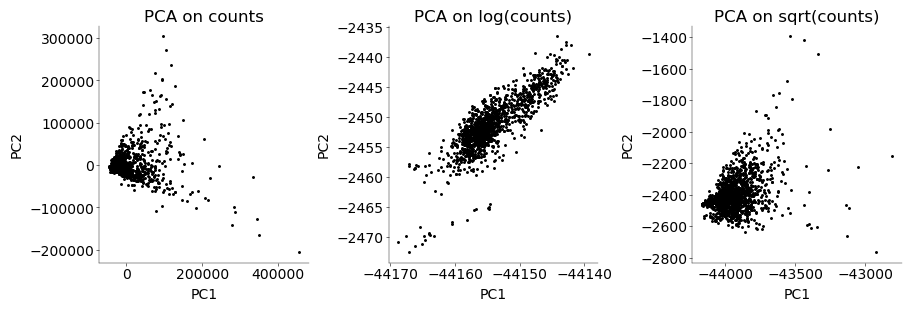

In [35]:
# plot pca results
fig, axs = plt.subplots(1, 3, figsize=(9, 3))


# add labels
for ax in axs:
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

# plot the data
for i, pca in enumerate(pcas):
    axs[i].scatter(pca[:, 0], pca[:, 1], s=5, color="black")


# add title
axs[0].set_title("PCA on counts")
axs[1].set_title("PCA on log(counts)")
axs[2].set_title("PCA on sqrt(counts)")


plt.show()

In [36]:
# from openTSNE import TSNE

# # Apply t-SNE to the 50 PCs
# tsne = TSNE()
# tsne_counts = tsne.fit(pca_counts[:, :50])

# tsne_log = TSNE(n_components=2, random_state=42)
# tsne_log_counts = tsne.fit(pca_log_counts[:, :50])

# tsne_sqrt = TSNE(n_components=2, random_state=42)
# tsne_sqrt_counts = tsne.fit(pca_sqrt_counts[:, :50])


# tsnes = [tsne_counts, tsne_log_counts, tsne_sqrt_counts]


# # Use default settings of openTSNE


# # You can also use sklearn if you want

# from sklearn.manifold import TSNE as TSNE_sk

# tsne_sk = TSNE_sk()
# tsne_counts_sk = tsne_sk.fit_transform(pca_counts[:, :50])
# tsne_log_counts_sk = tsne_sk.fit_transform(pca_log_counts[:, :50])
# tsne_sqrt_counts_sk = tsne_sk.fit_transform(pca_sqrt_counts[:, :50])

# tsnes_sk = [tsne_counts, tsne_log_counts, tsne_sqrt_counts]

In [37]:
# # plot the tsne data
# fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# # add labels
# for ax in axs:
#     ax.set_xlabel("t-SNE 1")
#     ax.set_ylabel("t-SNE 2")

# # plot the data
# for i, tsne in enumerate(tsnes):
#     axs[i].scatter(tsne[:, 0], tsne[:, 1], s=5, color="black")

# # add title
# axs[0].set_title("t-SNE on counts")
# axs[1].set_title("t-SNE on log(counts)")
# axs[2].set_title("t-SNE on sqrt(counts)")

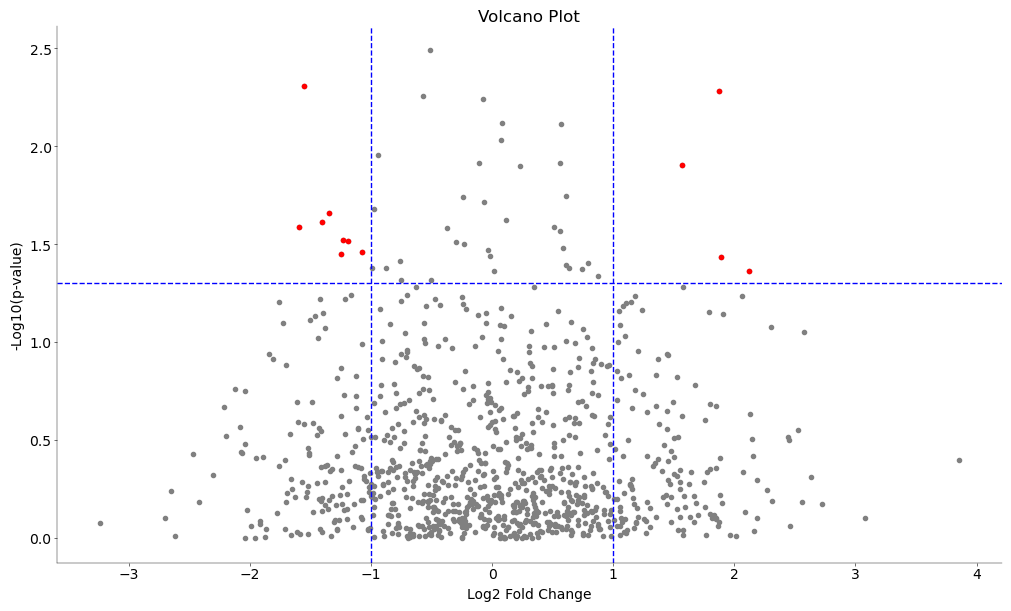

In [38]:
# dummy vulcano plot

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set a random seed for reproducibility
np.random.seed(42)

# Generate a dummy dataset
n = 1000
data = pd.DataFrame(
    {"log_fold_change": np.random.randn(n), "p_value": np.random.rand(n)}
)

# Calculate -log10(p-value)
data["-log10(p-value)"] = -np.log10(data["p_value"])

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(data["log_fold_change"], data["-log10(p-value)"], color="grey")

# Highlight significant points
significant = (data["p_value"] < 0.05) & (abs(data["log_fold_change"]) > 1)
plt.scatter(
    data.loc[significant, "log_fold_change"],
    data.loc[significant, "-log10(p-value)"],
    color="red",
)

# Adding labels and title
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10(p-value)")
plt.title("Volcano Plot")

# Adding threshold lines
plt.axhline(y=-np.log10(0.05), color="blue", linestyle="--")
plt.axvline(x=-1, color="blue", linestyle="--")
plt.axvline(x=1, color="blue", linestyle="--")

plt.show()

In [39]:
# function for data normalizations


def normalize_count_data(
    data_exons, method, data_genes=None, housekeeping_genes=["Actb", "Gapdh"]
):
    """
    Function to normalize data using a specified method

    Parameters
    ----------
    data_exons : np.ndarray
        The exon count read out data to normalize

    exonLengths : np.ndarray
        The exon lengths for each gene

    method : str
        The normalization method to use
        possible values: cpm, rpkm, tpm, housekeeping

    housekeeping_genes : list
        The housekeeping genes to use for normalization


    Returns
    -------
    np.ndarray
        The normalized data
    """

    # Create a normalization object
    nm = norm()

    if method == "cpm":
        # Perform CPM normalization
        nm.cpm(df=data_exons)
        # Get the CPM normalized data as np.array
        return nm.cpm_norm.to_numpy()

    elif method == "rpkm":
        # Merge the exon data with the gene lengths
        data_exons.index.name = "GeneID"
        # Perform the merge
        merged_exon_data = pd.merge(data_exons, data_genes, on="GeneID", how="left")
        merged_exon_data.set_index("GeneID", inplace=True)
        merged_exon_data = merged_exon_data.drop(columns=["intron_bp", "gene_bp"])
        # Perform RPKM normalization
        nm.rpkm(df=merged_exon_data, gl="exon_bp")

        return nm.rpkm_norm.to_numpy()

    elif method == "tpm":
        # Merge the exon data with the gene lengths
        data_exons.index.name = "GeneID"
        # Perform the merge
        merged_exon_data = pd.merge(data_exons, data_genes, on="GeneID", how="left")
        merged_exon_data.set_index("GeneID", inplace=True)
        merged_exon_data = merged_exon_data.drop(columns=["intron_bp", "gene_bp"])

        # Perform TPM normalization
        nm.tpm(df=merged_exon_data, gl="exon_bp")

        return nm.tpm_norm.to_numpy()

    elif method == "housekeeping":
        genes = data_exons.index
        # Find the indices of the housekeeping genes
        idx_housekeeping = [np.where(genes == hk)[0][0] for hk in housekeeping_genes]
        # Normalize each sample by the counts of housekeeping genes
        for i in range(exonCounts.shape[0]):  # For each sample
            norm_factor = exonCounts[
                i, idx_housekeeping
            ].mean()  # Average counts of housekeeping genes for the sample
            if norm_factor == 0:
                print(
                    f"Warning: Zero normalization factor in sample {i}, setting normalization factor to 1 to avoid division by zero."
                )
                norm_factor = 1
            exonCounts_norm[i] = exonCounts[i] / norm_factor

        return exonCounts_norm


# function for k nearest neighbours clustering
from sklearn.neighbors import NearestNeighbors


def knn_clusters(X, k=10):
    """
    Function to cluster data using k-nearest neighbors

    Parameters
    ----------
    X : np.ndarray
        The data to cluster
    k : int
        The number of neighbors to use

    Returns
    -------
    np.ndarray
        The cluster assignments
    """
    # Create a nearest neighbors model
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)
    # Find the nearest neighbors of each point
    distances, indices = nn.kneighbors(X)
    return indices


# function for gaussian mixture model clustering
from sklearn.mixture import GaussianMixture


def gmm_clusters(X, n_components=10):
    """
    Function to cluster data using a Gaussian Mixture Model

    Parameters
    ----------
    X : np.ndarray
        The data to cluster
    n_components : int
        The number of components to use in the GMM

    Returns
    -------
    np.ndarray
        The cluster assignments
    """
    # Create a Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_components)
    # Fit the model to the data
    gmm.fit(X)
    # Predict the cluster assignments
    return gmm.predict(X)


# function for nonlinear dimensionality reduction
from sklearn.manifold import TSNE


def tsne_embedding(X, n_components=2, perplexity=30, transform=None):
    """
    Function to embed data using t-SNE

    Parameters
    ----------
    X : np.ndarray
        The data to embed
    n_components : int
        The number of components to embed into
    perplexity : float
        The perplexity parameter for t-SNE
    transform : str
        The transformation to apply to the data before embedding
        possible values: 'sqrt', 'log'
    Returns
    -------
    np.ndarray
        The embedded data
    """

    # include log and square root transformations
    if transform == "sqrt":
        X = np.sqrt(X)
    elif transform == "log":
        X = np.log1p(X)

    # Create a t-SNE model for a given number of components and perplexity (if n_components is None use all components)
    tsne = TSNE(n_components=n_components, perplexity=perplexity)
    # Fit the model to the data and transform the data
    return tsne.fit_transform(X)


# function for umap clustering
import umap
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


def umap_clustering(data, n_components=2, n_neighbors=15, min_dist=0.1, n_clusters=3):
    """
    Perform UMAP dimensionality reduction and KMeans clustering on the given data.

    Parameters:
        data (array-like): The input data to be clustered.
        n_components (int): The number of dimensions to reduce the data to.
        n_neighbors (int): The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
        min_dist (float): The effective minimum distance between embedded points.
        n_clusters (int): The number of clusters for KMeans.

    Returns:
        labels (array): Cluster labels for each data point.
        embedding (array): The UMAP embedding of the data.
    """

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Perform UMAP dimensionality reduction
    umap_model = umap.UMAP(
        n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist
    )
    embedding = umap_model.fit_transform(scaled_data)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embedding)

    return labels, embedding


# plotting function for tsne and umap embeddings
def plot_embedding(embedding, labels, title="Embedding", ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    # Create a scatter plot of the data points
    scatter = ax.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=labels,
        cmap="tab10",
        s=5,
        alpha=0.8,
        rasterized=True,
    )

    # Add a legend
    legend = ax.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
    ax.add_artist(legend)

    # Add a title
    ax.set_title(title)
    ax.plot()



# function for principal component analysis

from sklearn.decomposition import PCA


def perform_pca(count_matrix, n_components=None, transformation=[], standardize=True):
    """
    Perform PCA on a given count matrix (cells x genes).

    Parameters:
    count_matrix (np.array): The input count matrix DataFrame (cells x genes).
    n_components (int, float, None or str): Number of components to keep.
        If n_components is not set all components are kept:
            n_components == min(n_samples, n_features)
        If n_components == 'mle' and svd_solver == 'full', Minka’s MLE is used to guess the dimension.
        If 0 < n_components < 1 and svd_solver == 'full', select the number of components such that
            the amount of variance that needs to be explained is greater than the percentage specified by n_components.
        If svd_solver == 'arpack', the number of components must be strictly less than the minimum of n_samples and n_features.
        Hence, the default value is None.
    transformation (list): List of normalizations to apply to the data before PCA.
        Possible values: 'log', 'sqrt'

    Returns:
    pd.DataFrame: DataFrame with the principal components.
    PCA: Fitted PCA object.
    """

    # Log-normalizing the data
    if "log" in transformation:
        # check for 0 values and print min value in data array
        if np.any(count_matrix <= 0):
            print(
                f"Warning: log-transforming data with zero or negative values with a min of {np.min(count_matrix)}. Adding small offset."
            )
            # add small offset to avoid log(0)
            count_matrix = count_matrix + 1
        # check again for 0 values
        if np.any(count_matrix <= 0):
            print("Warning: data still contains zero or negative values.")
        normalized_data = np.log1p(count_matrix)
    else:
        normalized_data = count_matrix.copy()

    # Square root-transforming the data
    if "sqrt" in transformation:
        normalized_data = np.sqrt(normalized_data)
    else:
        normalized_data = normalized_data.copy()

    # Standardizing the data
    if standardize:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(normalized_data)
    else:
        scaled_data = normalized_data

    # check if scaled data contains Nan
    if np.isnan(scaled_data).any():
        print("Warning: scaled data contains NaNs. Filling NaNs with 0.")
        scaled_data = np.nan_to_num(scaled_data)
    # Performing PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(scaled_data)

    # Creating a DataFrame with the principal components
    pc_df = pd.DataFrame(
        data=principal_components,
        columns=[f"PC{i+1}" for i in range(principal_components.shape[1])],
    )

    return pc_df, pca


# function for plotting pca_embedding


def plot_pca_embedding(embedding, labels, title="PCA Embedding", ax=None):
    """
    Function to plot a PCA embedding with cluster labels.

    Parameters
    ----------
    embedding : np.ndarray
        The PCA embedding of the data
    labels : np.ndarray
        The cluster labels for each data point
    title : str
        The title of the plot
    ax : matplotlib.axes.Axes
        The axes to plot on. If None, a new figure is created.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The axes object containing the plot
    """
    # Create a new figure if ax is not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    # Create a scatter plot of the data points
    scatter = ax.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=labels,
        cmap="tab10",
        s=5,
        alpha=0.8,
        rasterized=True,
    )

    # Add a legend
    legend = ax.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
    ax.add_artist(legend)

    # Add a title
    ax.set_title(title)
    # add axis titles
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    ax.plot()

c:\Users\Arne.Gittel\AppData\Local\anaconda3\envs\final_nds_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\Arne.Gittel\AppData\Local\anaconda3\envs\final_nds_env\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\Arne.Gittel\AppData\Local\anaconda3\envs\final_nds_env\li

cpm_exonCounts:  <class 'numpy.ndarray'>
(42466, 1329)


C:\Users\Arne.Gittel\AppData\Local\Temp\ipykernel_11448\3592546632.py:389: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
c:\Users\Arne.Gittel\AppData\Local\anaconda3\envs\final_nds_env\lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


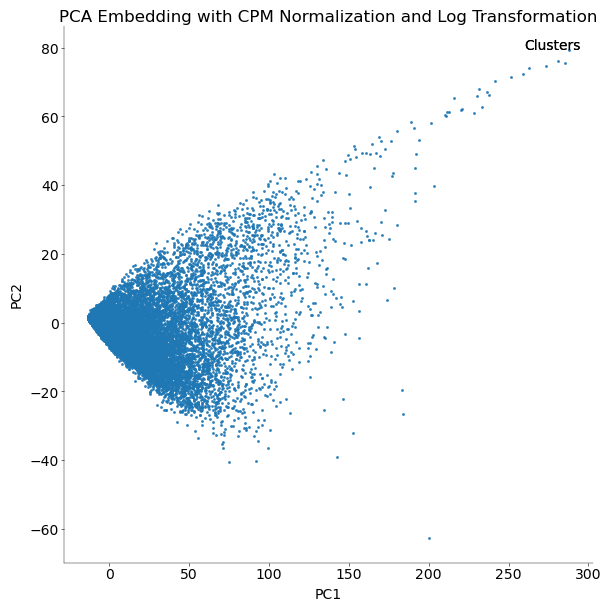

In [45]:
# get exon count data
exonCounts = data_exons
gene_length = data_genes
# normalise the data using cpm
cpm_exonCounts = normalize_count_data(exonCounts, data_genes=gene_length, method="tpm")
# give object type of cpm_exon counts
print("cpm_exonCounts: ", type(cpm_exonCounts))
print(cpm_exonCounts.shape)
# perform PCA on the normalised data with log transformation
pca_cpm, pca_cpm_model = perform_pca(
    cpm_exonCounts, transformation=["log"], standardize=True
)
# plot the pca embedding
plot_pca_embedding(
    pca_cpm.values,
    labels=None,
    title="PCA Embedding with CPM Normalization and Log Transformation",
)

In [41]:
# perform tsne on the pca data
tsne_pca_cpm = tsne_embedding(pca_cpm.values, perplexity=30)

c:\Users\Arne.Gittel\AppData\Local\anaconda3\envs\final_nds_env\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


C:\Users\Arne.Gittel\AppData\Local\Temp\ipykernel_11448\3592546632.py:225: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
c:\Users\Arne.Gittel\AppData\Local\anaconda3\envs\final_nds_env\lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


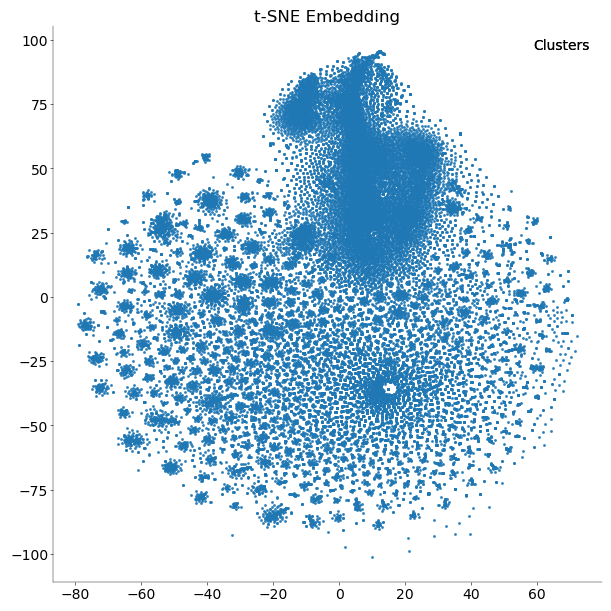

In [42]:
# plot the tsne embedding
plot_embedding(tsne_pca_cpm, labels=None, title="t-SNE Embedding", ax=None)

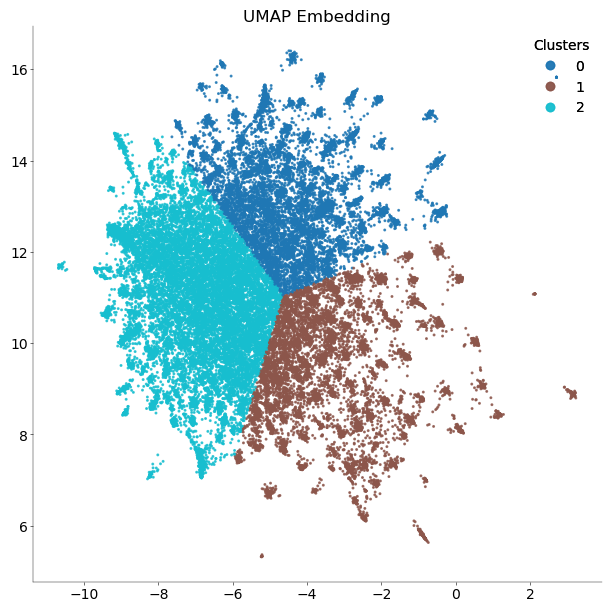

In [43]:
# perform umap clustering
umap_labels, umap_embedding = umap_clustering(
    pca_cpm.values, n_components=2, n_neighbors=15, min_dist=0.1, n_clusters=3
)

# plot the umap embedding
plot_embedding(umap_embedding, umap_labels, title="UMAP Embedding", ax=None)

TypeError: CEBRA.__init__() got an unexpected keyword argument 'n_components'